In [2]:
#pip install efficientnet

In [3]:
import numpy as np
import os
import pandas as pd
import kaggle
import matplotlib.pyplot as plt
import tensorflow as tf, tensorflow.keras.backend as K
import seaborn as sns
import random
import efficientnet.tfkeras as efn
import cv2
import hashlib
import plotly.express as px
import plotly.graph_objects as go


from tqdm import tqdm
from tensorflow.keras import optimizers
from PIL import Image

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed=13):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_KERAS'] = '1'
    random.seed(seed)

seed_everything(42)

In [5]:
def TPU():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print("Running on tpu", tpu.master())
    except ValueError:
        tpu = None
    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy()
    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return strategy

strategy = TPU()

REPLICAS:  1


In [6]:
AUTO = tf.data.experimental.AUTOTUNE

In [7]:
IMAGE_H = 512
IMAGE_W = 512
FOLDS = 5
SEED = 42
EPOCHS = 50
BATCH_SIZE = 8*strategy.num_replicas_in_sync

In [8]:
path = "A:/Programming/Python/NLP/Data files/Plant Pathology Project/plant-pathology-2020-fgvc7/"

train = pd.read_csv(path + "train.csv")
# for i in range(20):
#     print(train[i])
print(train.shape)


(1821, 5)


In [9]:
train_id = train['image_id']

In [10]:
for i in train_id:
    print(i)

Train_0
Train_1
Train_2
Train_3
Train_4
Train_5
Train_6
Train_7
Train_8
Train_9
Train_10
Train_11
Train_12
Train_13
Train_14
Train_15
Train_16
Train_17
Train_18
Train_19
Train_20
Train_21
Train_22
Train_23
Train_24
Train_25
Train_26
Train_27
Train_28
Train_29
Train_30
Train_31
Train_32
Train_33
Train_34
Train_35
Train_36
Train_37
Train_38
Train_39
Train_40
Train_41
Train_42
Train_43
Train_44
Train_45
Train_46
Train_47
Train_48
Train_49
Train_50
Train_51
Train_52
Train_53
Train_54
Train_55
Train_56
Train_57
Train_58
Train_59
Train_60
Train_61
Train_62
Train_63
Train_64
Train_65
Train_66
Train_67
Train_68
Train_69
Train_70
Train_71
Train_72
Train_73
Train_74
Train_75
Train_76
Train_77
Train_78
Train_79
Train_80
Train_81
Train_82
Train_83
Train_84
Train_85
Train_86
Train_87
Train_88
Train_89
Train_90
Train_91
Train_92
Train_93
Train_94
Train_95
Train_96
Train_97
Train_98
Train_99
Train_100
Train_101
Train_102
Train_103
Train_104
Train_105
Train_106
Train_107
Train_108
Train_109
Train_110


In [11]:
train.pop("image_id")

0          Train_0
1          Train_1
2          Train_2
3          Train_3
4          Train_4
           ...    
1816    Train_1816
1817    Train_1817
1818    Train_1818
1819    Train_1819
1820    Train_1820
Name: image_id, Length: 1821, dtype: object

In [12]:
y_train = train.to_numpy().astype("float32")

In [13]:
category_names = ['healthy','multiple_diseases','rust','scab']
root = 'images'

images_id = [(os.path.join(path, root, idee)) for idee in train_id]

In [14]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

cols = list(train_df.columns[1:])

train_ids = train_df['image_id']
train_images = train_ids.apply(lambda x: path+'images'+x+'.jpg')
test_ids = test_df['image_id']
test_images = test_ids.apply(lambda x: path+'images'+x+'.jpg')

train_labels = train_df.iloc[:,1:].values

In [15]:
#EDA

In [16]:
len(train_df), len(test_df)

(1821, 1821)

In [17]:
print(cols)

['healthy', 'multiple_diseases', 'rust', 'scab']


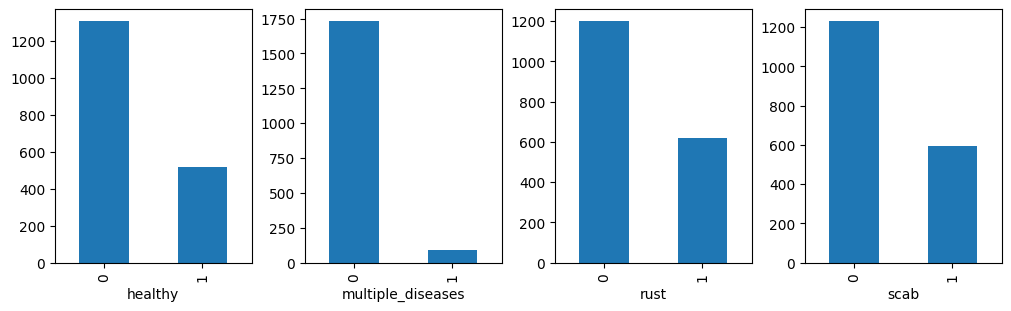

In [18]:
_, ax = plt.subplots(ncols=4, nrows=1, constrained_layout=True, figsize=(10, 3))

for column, ax in zip(cols, ax):
    train_df[column].value_counts().plot.bar(ax=ax)

plt.show()

<Axes: title={'center': 'Label distribution'}>

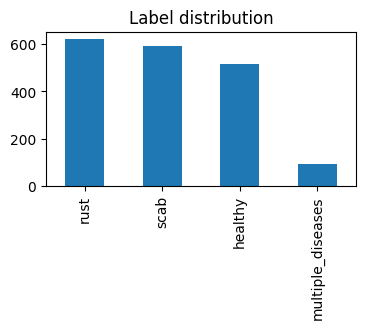

In [19]:
plt.title("Label distribution")
train_df[cols].idxmax(axis=1).value_counts().plot.bar(figsize=(4, 2))

In [20]:
train_df[cols].sum(axis=1).unique()

array([1], dtype=int64)

In [21]:
def calculate_hash(im):
    md5 = hashlib.md5()
    md5.update(np.array(im).tostring())
    return md5.hexdigest()

def get_image_meta(image_id, image_src, dataset='train'):
    im = Image.open(image_src)
    extrema = im.getextrema()
    meta = {
        'image_id': image_id,
        'hash': calculate_hash(im),
        'dataset': dataset,
        'r_min': extrema[0][0],
        'r_max': extrema[0][1],
        'g_min': extrema[1][0],
        'g_max': extrema[1][1],
        'b_min': extrema[2][0],
        'b_max': extrema[2][1],
        'format': im.format,
        'mode': im.mode
    }
    return meta

In [28]:
data = []

for i, image_id in enumerate(tqdm(train_df['image_id'].values, total=train_df.shape[0])):
    data.append(get_image_meta(image_id, path+'images/'+image_id+'.jpg'))

100%|██████████████████████████████████████████████████████████████████████████████| 1821/1821 [06:35<00:00,  4.60it/s]


In [29]:
for i, image_id in enumerate(tqdm(test_df['image_id'].values, total=test_df.shape[0])):
    data.append(get_image_meta(image_id, path+'images/'+image_id+'.jpg', 'test'))


100%|██████████████████████████████████████████████████████████████████████████████| 1821/1821 [06:14<00:00,  4.87it/s]


In [31]:
len(data)

3642

In [8]:
meta_df = pd.DataFrame(data)
meta_df.head()

,image_id,hash,dataset,r_min,r_max,g_min,g_max,b_min,b_max,format,mode
0,Train_0,db4bf65abb3885f11affb0f05d9626fc,train,15,251,14,255,0,249,JPEG,RGB
1,Train_1,ff0c174254ce4e8c81a1c0f18a47755a,train,40,255,24,255,1,255,JPEG,RGB
2,Train_2,b343fc39af28b38295f8d525a46c7e95,train,19,255,34,255,10,255,JPEG,RGB
3,Train_3,c057d42953a1b1b0cf04c5f648587bee,train,20,255,26,255,0,255,JPEG,RGB
4,Train_4,52ce8960e37448661a3377b2bd0d8d33,train,20,236,46,255,7,248,JPEG,RGB


In [9]:
meta_df['hash'].nunique()

3637

In [10]:
import dill

dill.dump_session("PlantPathology1.db")

In [11]:
height_array = []
width_array = []
for img_id in meta_df['image_id']:
    img_src = path+ "images/" + img_id + ".jpg"
    im = Image.open(img_src)
    height_array.append(im.size[0])
    width_array.append(im.size[1])
meta_df["height"] = height_array
meta_df["width"] = width_array

In [12]:
meta_df.groupby(by="dataset")[['width', 'height']].aggregate(['min', 'max'])

width       height      
          min   max    min   max
dataset                         
test     1365  2048   1365  2048
train    1365  2048   1365  2048

In [13]:
#duplicates

duplicates = meta_df.groupby("hash")[['image_id']].count().reset_index()

In [14]:
duplicates

,hash,image_id
0,000e060ab130eab477dc42cc0282af4b,1
1,0018bc6e41cd57ed0e9888e905f7f8d1,1
2,001b72d8bee66a8b451c031ea93b00d2,1
3,00302b481cb18a4a38b8598c9f27d202,1
4,003a4a9f054e6827855c36003d799721,1
...,...,...
3632,ffaae3d319d35ec38c85a1cc15d5ffe7,1
3633,ffd853cefac0bf4b7d7cf076dd9b6307,1
3634,ffd9632fd3c718cb50c4fd4a4b4dd1ef,1
3635,ffe51394e6992f13ed20ecdc34e2d630,1


In [15]:
duplicates = duplicates[duplicates['image_id']>1]

In [16]:
duplicates

,hash,image_id
262,124caa31810068da4359fc97146b079b,2
401,1c1658929a2ecfc99c92908d43ca2dd1,2
1227,55b7929568c477a59c1c0f9b5d2f56ad,2
2437,a937893a0b73dfed5cc84afa50d325e2,2
2464,abb10477d7680c03b8e55817ecd487b4,2


In [17]:
duplicates.reset_index(drop=True, inplace=True)

In [18]:
duplicates

,hash,image_id
0,124caa31810068da4359fc97146b079b,2
1,1c1658929a2ecfc99c92908d43ca2dd1,2
2,55b7929568c477a59c1c0f9b5d2f56ad,2
3,a937893a0b73dfed5cc84afa50d325e2,2
4,abb10477d7680c03b8e55817ecd487b4,2


In [19]:
duplicates = duplicates.merge(meta_df[["image_id", "hash"]], on="hash")

In [20]:
duplicates

,hash,image_id_x,image_id_y
0,124caa31810068da4359fc97146b079b,2,Train_1703
1,124caa31810068da4359fc97146b079b,2,Test_1407
2,1c1658929a2ecfc99c92908d43ca2dd1,2,Train_1505
3,1c1658929a2ecfc99c92908d43ca2dd1,2,Test_829
4,55b7929568c477a59c1c0f9b5d2f56ad,2,Train_379
5,55b7929568c477a59c1c0f9b5d2f56ad,2,Train_1173
6,a937893a0b73dfed5cc84afa50d325e2,2,Test_683
7,a937893a0b73dfed5cc84afa50d325e2,2,Test_1691
8,abb10477d7680c03b8e55817ecd487b4,2,Test_570
9,abb10477d7680c03b8e55817ecd487b4,2,Test_1212


In [21]:
dill.dump_session("PlantPathology2.db")

In [22]:
duplicates

,hash,image_id_x,image_id_y
0,124caa31810068da4359fc97146b079b,2,Train_1703
1,124caa31810068da4359fc97146b079b,2,Test_1407
2,1c1658929a2ecfc99c92908d43ca2dd1,2,Train_1505
3,1c1658929a2ecfc99c92908d43ca2dd1,2,Test_829
4,55b7929568c477a59c1c0f9b5d2f56ad,2,Train_379
5,55b7929568c477a59c1c0f9b5d2f56ad,2,Train_1173
6,a937893a0b73dfed5cc84afa50d325e2,2,Test_683
7,a937893a0b73dfed5cc84afa50d325e2,2,Test_1691
8,abb10477d7680c03b8e55817ecd487b4,2,Test_570
9,abb10477d7680c03b8e55817ecd487b4,2,Test_1212


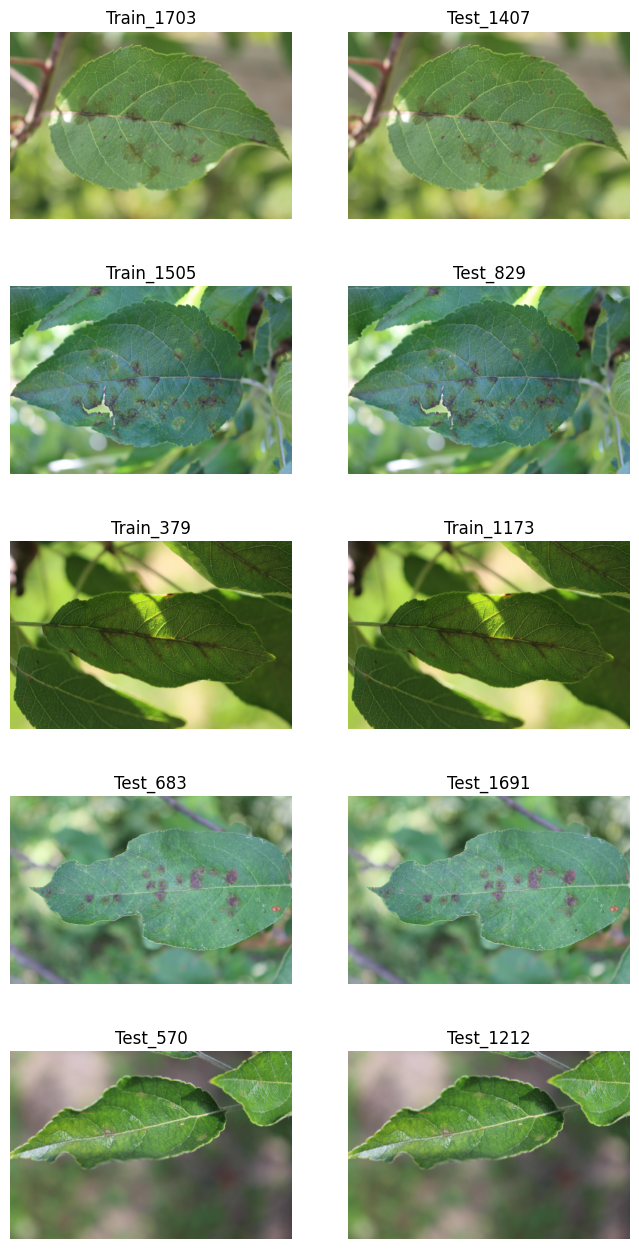

In [26]:
fig, ax = plt.subplots(5, 2, figsize=(8, 16))
ax = ax.flatten()

for i in range(0, 10, 2):
    image_i = cv2.imread(path+ "images/{}.jpg".format(duplicates.iloc[i, 2]), cv2.IMREAD_COLOR)
    image_i = cv2.cvtColor(image_i, cv2.COLOR_BGR2RGB)
    ax[i].set_axis_off()
    ax[i].imshow(image_i)
    ax[i].set_title(duplicates.iloc[i, 2])
    image_i1 = cv2.imread(path+ "images/{}.jpg".format(duplicates.iloc[i+1, 2]), cv2.IMREAD_COLOR)
    image_i1 = cv2.cvtColor(image_i1, cv2.COLOR_BGR2RGB)
    ax[i+1].set_axis_off()
    ax[i+1].imshow(image_i1)
    ax[i+1].set_title(duplicates.iloc[i+1, 2])